In [3]:
import os
import math
import numpy
from scipy import integrate
from matplotlib import pyplot
# display the figures in the Notebook
%matplotlib inline

In [4]:
x_wing,y_wing = numpy.loadtxt(open("MainFoil_N=200.csv","rb"),delimiter=",",skiprows=0,unpack=True) 
x_flap,y_flap = numpy.loadtxt(open("FlapFoil_N=200.csv","rb"),delimiter=",",skiprows=0,unpack=True)

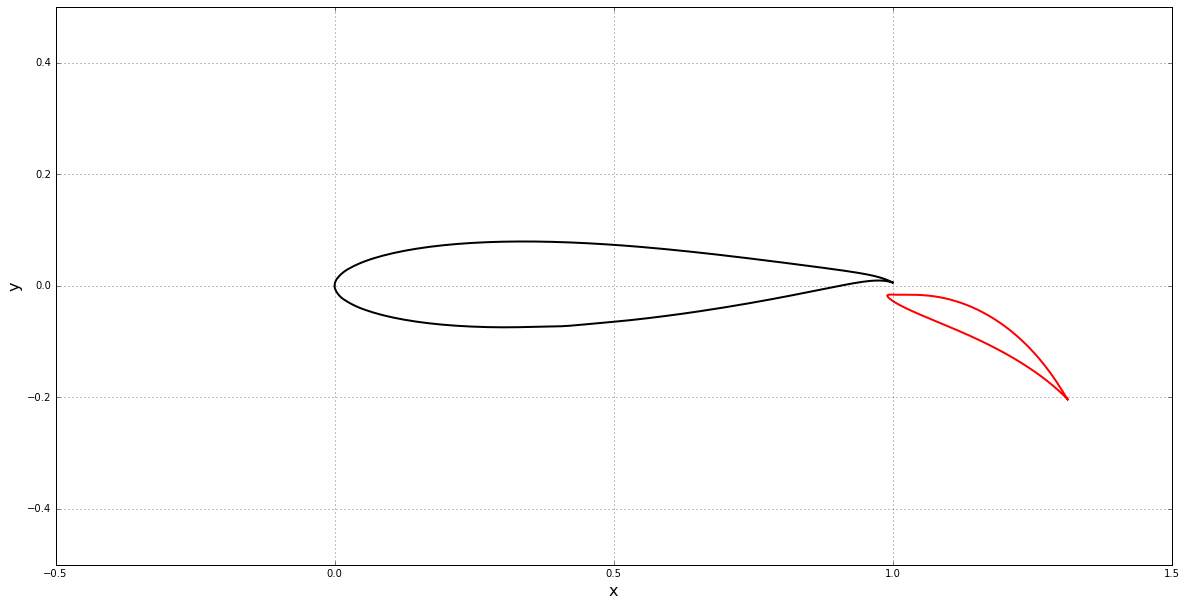

In [5]:
# plot the geometry
width = 20
pyplot.figure(figsize=(width, width))
pyplot.grid()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_wing,y_wing, color='k', linestyle='-', linewidth=2)
pyplot.plot(x_flap,y_flap, color='red', linestyle='-', linewidth=2)
pyplot.axis('scaled', adjustable='box')
pyplot.xlim(-0.5, 1.5)
pyplot.ylim(-0.5, 0.5);

In [6]:
class Panel:
  
    def __init__(self, xa, ya, xb, yb):
  
        self.xa, self.ya = xa, ya # panel starting-point
        self.xb, self.yb = xb, yb # panel ending-point
        
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2         # panel center
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2) # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb-xa <= 0.0:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper' # upper surface
        else:
            self.loc = 'lower' # lower surface
        
        self.sigma = 0.0 # source strength
        self.vt = 0.0    # tangential velocity
        self.cp = 0.0    # pressure coefficient

In [7]:
def define_panels(x, y, N):
    # create panels
    panels = numpy.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i+1], y[i+1])
    
    return panels

In [8]:
N=numpy.size(x_wing)-1

In [9]:
panels_wing = define_panels(x_wing, y_wing, N)
panels_flap = define_panels(x_flap, y_flap, N)
total_panels = numpy.concatenate((panels_wing,panels_flap))

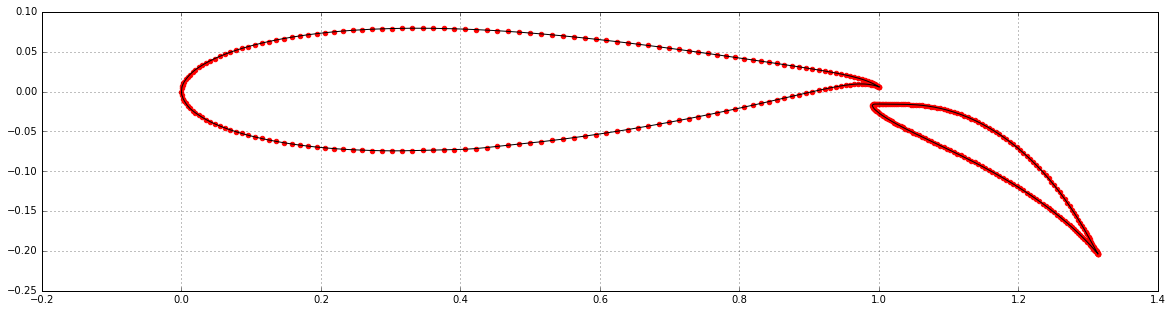

In [10]:
pyplot.figure(figsize=(20,5))
pyplot.plot(x_wing, y_wing, x_flap, y_flap,  color='k', linestyle='-', linewidth=1);
pyplot.grid(True)
panel_main, panel_flap = define_panels(x_wing, y_wing, N), define_panels(x_flap, y_flap, N)
pyplot.scatter([panel.xa for panel in panel_main], [panel.ya for panel in panel_main], color='red');
pyplot.scatter([panel.xa for panel in panel_flap], [panel.ya for panel in panel_flap], color='red');

In [11]:
class Freestream:

    def __init__(self, u_inf=1.0, alpha=0.0):

        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180.0 # degrees to radians

In [65]:
# define freestream conditions
freestream = Freestream(u_inf=1.0, alpha=0.0)

In [66]:
def integral(x, y, panel, dxdk, dydk):
 
    def integrand(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdk
                  +(y - (panel.ya + numpy.cos(panel.beta)*s))*dydk)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2
                   +(y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [67]:
def source_contribution_normal(panels):

    A = numpy.empty((panels.size, panels.size), dtype=float)
    # source contribution on a panel from itself
    numpy.fill_diagonal(A, 0.5)
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                panel_j,
                                                numpy.cos(panel_i.beta),
                                                numpy.sin(panel_i.beta))
    return A

In [68]:
def vortex_contribution_normal(panels):
 
    A = numpy.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    numpy.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5/numpy.pi*integral(panel_i.xc, panel_i.yc, 
                                                 panel_j,
                                                 numpy.sin(panel_i.beta),
                                                 -numpy.cos(panel_i.beta))
    return A

In [69]:
A_source=source_contribution_normal(total_panels)
B_vortex= vortex_contribution_normal(total_panels)

In [70]:
print(A_source.shape[0])


400


In [71]:
def kutta_condition(A_source, B_vortex):
   
    b = numpy.empty([2,A_source.shape[0]+2],dtype=float)
    M = len(x_wing)+len(x_flap)-2
   
    b[0,:-2] = B_vortex[0, :] + B_vortex[M/2-1, :]
    b[1,:-2] = B_vortex[M/2, :] + B_vortex[M-1, :]
    
    b[-2,-2]=- numpy.sum(A_source[0,:M/2] + A_source[M/2-1,:M/2])
    b[-2,-1]=- numpy.sum(A_source[0,M/2:] + A_source[M/2-1,M/2:])
    
    b[-1,-2]=- numpy.sum(A_source[M/2,:M/2] + A_source[M-1,:M/2])
    b[-1,-1]=- numpy.sum(A_source[M/2,M/2:] + A_source[M-1,M/2:])
    return b

In [72]:
def build_singularity_matrix(A_source, B_vortex):
    A = numpy.empty((A_source.shape[0]+2, A_source.shape[0]+2), dtype=float)
    M = len(x_wing)+len(x_flap)-2
    # source contribution matrix
    A[:-2, :-2] = A_source
    # vortex contribution array
    A[:-2, -2] = numpy.sum(B_vortex[:,:M/2], axis=1)    
    A[:-2, -1] = numpy.sum(B_vortex[:,M/2:], axis=1)
    # Kutta condition array
    A[-2:, :] = kutta_condition(A_source, B_vortex)
    
    return A

In [73]:
def build_freestream_rhs(panels, freestream):
    b = numpy.empty(panels.size+2,dtype=float)
    M = len(x_wing)+len(x_flap)-2
    for i, panel in enumerate(panels):
        b[i] = - freestream.u_inf * math.cos(freestream.alpha - panel.beta)
    
    b[-2] = -freestream.u_inf*( math.sin(freestream.alpha-panels[0].beta)
                              +math.sin(freestream.alpha-panels[M/2-1].beta) )
    b[-1] = -freestream.u_inf*( math.sin(freestream.alpha-panels[M/2].beta)
                              +math.sin(freestream.alpha-panels[M-1].beta) )
    
    return b

In [74]:
A = build_singularity_matrix(A_source, B_vortex)
b = build_freestream_rhs(total_panels, freestream)

/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/gil/anaconda3/lib/python3.5/site-packages/ipykernel/__main

In [75]:
# solve for singularity strengths
strengths = numpy.linalg.solve(A, b)

# store source strength on each panel
for i , panel in enumerate(total_panels):
    panel.sigma = strengths[i]
    
# store circulation density
gamma=numpy.append(strengths[-1], strengths[-2])

In [76]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    A = numpy.empty((panels.size, panels.size+2), dtype=float)
    A[:, :-2] = B_vortex
    A[:, -2] = -numpy.sum(A_source[:,:N], axis=1)
    A[:, -1] = -numpy.sum(A_source[:,N:], axis=1)
    b = freestream.u_inf*numpy.sin([freestream.alpha-panel.beta 
                                    for panel in panels])
    
    strengths = numpy.append([panel.sigma for panel in panels],gamma)
    tangential_velocities = numpy.dot(A, strengths) + b
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [77]:
def compute_pressure_coefficient(panels, freestream):
    """
    Computes the surface pressure coefficients.
    
    Parameters
    ----------
    panels: 1D array of Panel objects
        List of panels.
    freestream: Freestream object
        Freestream conditions.
    """
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [78]:
compute_pressure_coefficient(total_panels, freestream)
compute_tangential_velocity(total_panels, freestream, gamma, A_source, B_vortex)

In [79]:
def get_velocity_field(panels, freestream, X, Y):
    """Returns the velocity field.
    
    Arguments
    ---------
    panels -- array of panels.
    freestream -- farfield conditions.
    X, Y -- mesh grid.
    """
    Nx, Ny = X.shape
    u, v = numpy.empty((Nx, Ny), dtype=float), numpy.empty((Nx, Ny), dtype=float)
    
    for i in range(Nx):
        for j in range(Ny):
            u[i,j] = freestream.u_inf*math.cos(freestream.alpha)\
                     + 0.5/math.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 1, 0) for p in panels])
            v[i,j] = freestream.u_inf*math.sin(freestream.alpha)\
                     + 0.5/math.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 0, 1) for p in panels])
    
    return u, v

### introducing the old data and plot results in one picture

In [80]:
X_wing,Y_wing = numpy.loadtxt(open("Cp_Flap_theoretical.csv","rb"),delimiter=",",skiprows=0,unpack=True) 
X_flap,yY_flap = numpy.loadtxt(open("Cp_Main_theoretical.csv","rb"),delimiter=",",skiprows=0,unpack=True)

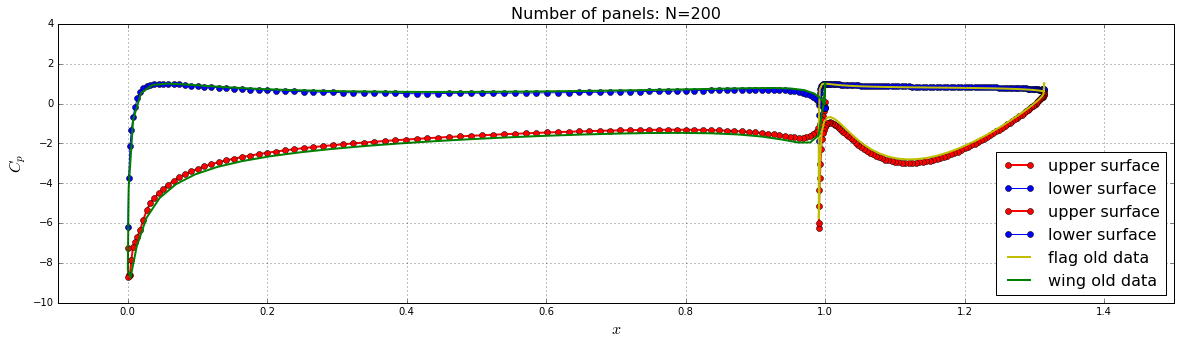

In [81]:
# plot surface pressure coefficient
pyplot.figure(figsize=(20, 5))
pyplot.grid()
pyplot.xlabel('$x$', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in total_panels[:N]if panel.loc == 'upper'],
            [panel.cp for panel in total_panels[:N] if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in total_panels[N:] if panel.loc == 'lower'],
            [panel.cp for panel in total_panels[N:] if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)

pyplot.plot([panel.xc for panel in total_panels[N:]if panel.loc == 'upper'],
            [panel.cp for panel in total_panels[N:] if panel.loc == 'upper'],
            label='upper surface',
            color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in total_panels[:N] if panel.loc == 'lower'],
            [panel.cp for panel in total_panels[:N] if panel.loc == 'lower'],
            label= 'lower surface',
            color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.plot(X_wing,Y_wing, label="flag old data",color='y', linestyle='-', linewidth=2)
pyplot.plot(X_flap,yY_flap, label="wing old data",color='g', linestyle='-', linewidth=2)
pyplot.legend(loc='best', prop={'size':16})
pyplot.xlim(-0.1, 1.5)
pyplot.ylim(-10, 4.0)
pyplot.title('Number of panels: N=200', fontsize=16);

In [82]:
L,D=0,0
for panel in total_panels:
    L -= panel.cp * panel.length * math.sin(panel.beta)
    D += panel.cp * panel.length * math.cos(panel.beta)

print (L)

3.54317890336


### Accuracy check

In [83]:
accuracy = sum([panel.sigma*panel.length for panel in total_panels])
print('sum of singularity strengths: {:0.6f}'.format(accuracy))

sum of singularity strengths: -0.000827


In [84]:
a=3.71843390868
b=3.69771447686
c=((a-b)/b)*0.01

print(c,"%")

5.6033076511614004e-05 %
